**<h1 align="center">Universidad Internacional del Ecuador</h1>**

**<h2 align="center">Procesamiento de Imágenes y Señales</h2>**

***<h3 align="left">Grupo 6</h3>***
- ***<h3 align="left">Dario Wladimir Herrera Chávez</h3>***
- ***<h3 align="left">Jonathan Fabricio Gualli Ramirez</h3>***
- ***<h3 align="left">Jorge Armando Quizamanchuro Fuel</h3>***

> **Nota**
>
> Ejecuta el notebook en orden secuencial para que las funciones declaradas en el primer bloque puedan ser usadas en las otras secciones.

## Objetivos

## Desarrollo

- En primera instancia, se desarrolla un módulo utilitario de funciones que servirá como soporte a lo largo de todo el proyecto. Este módulo centraliza procesos repetitivos y facilita la reutilización de código, permitiendo una implementación más organizada.

In [1]:
import os
import cv2
import time
import random
import shutil
import matplotlib.pyplot as plt
import numpy as np
from typing import List
from sklearn.model_selection import train_test_split

matplot_style: str = "default"
all_images_path: str = "resources/dataset/soldadura/all"
test_images_path: str = "resources/dataset/soldadura/test"
train_images_path: str = "resources/dataset/soldadura/train"
target_image_path: str = "resources/dataset/soldadura/all/1734589460685.tif"
train_size_value: float = 0.8
randon_state_value: int = 42
black: int = 0
white: int = 255
roi_matrix_shape = (7,7)
border_matrix_shape = (5,5)


def get_area_by_mask(mask):
    return np.sum(mask == 255)

def mask_apply(image, mask):
    return cv2.bitwise_and(image, image, mask=mask)

def kmeans_with_roi_image(image, mask, n_clusters = 5):
    roi_pixels = image[mask == 255]

    if len(roi_pixels) < n_clusters:
        print("Reducing the number of clusters automatically.")
        n_clusters = max(1, len(roi_pixels))

    roi_pixels = np.float32(roi_pixels.reshape(-1,1))
    criteria = (
        cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER,
        100,
        0.2
    )
    _, labels, centers = cv2.kmeans(
        roi_pixels,
        n_clusters,
        None,
        criteria,
        10,
        cv2.KMEANS_RANDOM_CENTERS
    )

    centers = centers.flatten()
    labels = labels.flatten()
    segmented = np.zeros_like(image)
    segmented[mask == 255] = centers[labels]
    return segmented, centers

def set_matplot_style(style):
    plt.style.use(style)
    return None

def copy_images(split_images, root_path, destination_path):
    for file in split_images:
        shutil.copy2(os.path.join(root_path, file), os.path.join(destination_path, file))
    return None

def split_images_in_groups(test_path, train_path, train_size, random_state):
    os.makedirs(test_path, exist_ok=True)
    os.makedirs(train_path, exist_ok=True)

    all_images = os.listdir(all_images_path)
    tr_images, te_images = train_test_split(all_images, train_size = train_size, random_state = random_state)
    copy_images(tr_images, all_images_path, train_images_path)
    copy_images(te_images, all_images_path, test_images_path)

    print("################################################")
    print("                   Summary                      ")
    print("################################################")
    print(f"> Number of Images: {len(all_images)}")
    print(f"> Number of Train Images copied: {len(tr_images)}")
    print(f"> Number of Test Images copied: {len(te_images)}")
    print("################################################")
    return None

def show_summary(msk1, msk2, msk3):
    print("##################################################################################")
    print("                                     Summary                                      ")
    print("##################################################################################")
    print(f"> Area with prepare_and_get_roi_on_image method: {get_area_by_mask(msk1)}")
    print(f"> Area with prepare_and_get_roi_on_image_with_border method: {get_area_by_mask(msk2)}")
    print(f"> Area with prepare_and_get_roi_on_image_with_watershed method: {get_area_by_mask(msk3)}")
    print("#################################################################################")
    return None

def plot_roi_result(trg_image, custom_mask, segmented_type):
    target_roi_image = mask_apply(trg_image, custom_mask)

    custom_segmented_roi, centers = kmeans_with_roi_image(target_roi_image, custom_mask, 5)
    print("Centroides:", centers.flatten())

    set_matplot_style(matplot_style)
    plt.figure(figsize=(15,5))

    plt.subplot(1,3,1)
    plt.imshow(trg_image, cmap='gray')
    plt.title("Imágen Original")
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.imshow(target_roi_image, cmap='gray')
    plt.title(f"ROI segmentada | {segmented_type}")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(custom_segmented_roi, cmap='jet')
    plt.title(f"KMeans ROI segmentada | {segmented_type}")
    plt.axis('off')
    return None

* Como etapa inicial del procesamiento, se procede a dividir el conjunto de datos, conformado por fotografías del proceso de soldadura, en subconjuntos de entrenamiento (train) y prueba (test). Esta separación permite estructurar adecuadamente la información para el desarrollo, validación y evaluación de los modelos y técnicas que serán aplicados en etapas posteriores del procesamiento y análisis de imágenes.

In [2]:
set_matplot_style(matplot_style)
split_images_in_groups(test_images_path, train_images_path, train_size_value, randon_state_value)

################################################
                   Summary                      
################################################
> Number of Images: 348
> Number of Train Images copied: 278
> Number of Test Images copied: 70
################################################


* Una vez con nuestro dataset divido, procedemos a crear nuestros métodos para poder preparar las imágenes.

> Los métodos presentados a continuación reciben una imagen como entrada, la cual es sometida a una serie de etapas de preprocesamiento que incluyen filtrado, umbralización y operaciones de morfología matemática. El objetivo de estos procesos es mejorar la calidad de la imagen original, reducir el ruido y resaltar las características relevantes, permitiendo así identificar y delimitar de manera más precisa el área de interés (ROI).

- #### *prepare_and_get_roi_on_image (M1)*

In [3]:
def prepare_and_get_roi_on_image(image):
    blur_image = cv2.GaussianBlur(image, roi_matrix_shape, 0)

    _, image_threshed = cv2.threshold(
        blur_image, black, white,
        cv2.THRESH_BINARY + cv2.THRESH_OTSU
    )

    kernel = np.ones(roi_matrix_shape, np.uint8)
    opening = cv2.morphologyEx(image_threshed, cv2.MORPH_OPEN, kernel)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)
    binary_image_num_labels, binary_image_labels, stats, _ = cv2.connectedComponentsWithStats(closing)

    if binary_image_num_labels > 1:
        largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])

        mask = np.zeros_like(image)
        mask[binary_image_labels == largest_label] = white
    else:
        mask = closing

    return mask

- #### *prepare_and_get_roi_on_image_with_border (M2)*

In [4]:
def prepare_and_get_roi_on_image_with_border(image):
    blur_image = cv2.GaussianBlur(image, border_matrix_shape, 0)

    edges = cv2.Canny(blur_image, 5, 50)
    kernel = np.ones(border_matrix_shape, np.uint8)
    dilated = cv2.dilate(edges, kernel, iterations=2)
    closed = cv2.morphologyEx(dilated, cv2.MORPH_CLOSE, kernel)

    binary_image_contours, _ = cv2.findContours(
        closed,
        cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE
    )

    mask = np.zeros_like(image)

    if len(binary_image_contours) > 0:
        largest = max(binary_image_contours, key=cv2.contourArea)
        cv2.drawContours(mask, [largest], -1, 255, -1)

    return mask

- #### *prepare_and_get_roi_on_image_with_watershed (M3)*

In [5]:
def prepare_and_get_roi_on_image_with_watershed(image):
    blur_image = cv2.GaussianBlur(image, roi_matrix_shape, 0)

    _, image_threshed = cv2.threshold(
        blur_image, black, white,
        cv2.THRESH_BINARY + cv2.THRESH_OTSU
    )

    kernel = np.ones((3,3), np.uint8)
    opening = cv2.morphologyEx(image_threshed, cv2.MORPH_OPEN, kernel, iterations=2)
    sure_bg = cv2.dilate(opening, kernel, iterations=3)
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)

    _, sure_fg = cv2.threshold(
        dist_transform,
        0.5 * dist_transform.max(),
        255, 0
    )

    sure_fg = np.uint8(sure_fg)
    unknown_region = cv2.subtract(sure_bg, sure_fg)
    num_labels, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown_region == 255] = 0
    img_color = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    markers = cv2.watershed(img_color, markers)
    mask = np.zeros_like(image)
    mask[markers > 1] = 255

    return mask

* Con los métodos establecidos, se pueden identificar la siguiente diferencias:

<center>

|                M1                 |              M2               |                M3                |
|:---------------------------------:|:-----------------------------:|:--------------------------------:|
|      Segmenta por intensidad      |      Segmenta por forma       |      Segmenta por regiones       |
|         Usa umbral (Otsu)         |         Usa gradiente         |          Usa marcadores          |
|      Usa componentes conexos      |         Usa contornos         |  Usa transformada de distancia   |
|         Basado en brillo          |      Basado en frontera       |       Basado en topología        |
|        Separa fondo-objeto        |   Detecta discontinuidades    |  Separa regiones por inundación  |
| Robusto ante transiciones suaves  | Sensible a gradientes débiles | Robusto ante regiones adyacentes |

</center>

* Analizadas las fortalezas y debilidades de cada función de segmentación, se procede a ejecutar cada una de ellas con el objetivo de evaluar su desempeño práctico y comparar visual y cuantitativamente los resultados obtenidos.

> [!NOTE]
> <br>
> Por motivos académicos únicamente se seleccionará una sola imagen del grupo del dataset para evaluar y presentar de mejor manera los resultados.

In [6]:
target_image = cv2.imread(target_image_path, cv2.IMREAD_GRAYSCALE)

mask_method_with_threshold = prepare_and_get_roi_on_image(target_image)
mask_method_with_gradient = prepare_and_get_roi_on_image_with_border(target_image)
mask_method_with_markers = prepare_and_get_roi_on_image_with_watershed(target_image)

show_summary(mask_method_with_threshold, mask_method_with_gradient, mask_method_with_markers)

##################################################################################
                                     Summary                                      
##################################################################################
> Area with prepare_and_get_roi_on_image method: 6069
> Area with prepare_and_get_roi_on_image_with_border method: 3175
> Area with prepare_and_get_roi_on_image_with_watershed method: 4834
#################################################################################


#### *Análisis cuantitativo*

- A partir del análisis comparativo del área segmentada por cada método, se concluye que el método basado en umbralización presenta el mejor desempeño en la delimitación de la zona de interés, logrando una segmentación más completa y consistente.

- El método basado en gradientes muestra un rendimiento inferior, evidenciando una sub-segmentación significativa debido a la naturaleza suave de las transiciones térmicas en la imagen.

- Por su parte, el método basado en marcadores (watershed) ofrece un resultado intermedio, proporcionando una segmentación más controlada y estructuralmente coherente, aunque ligeramente más conservadora que la obtenida mediante umbralización.

Ahora procedemos a corroborar de manera gráfica los resultados del área de interés

- #### *Máscara segmentada por intensidad (M1)*

Centroides: [ 90.38746  137.63829  107.30224   94.945595  99.98834 ]


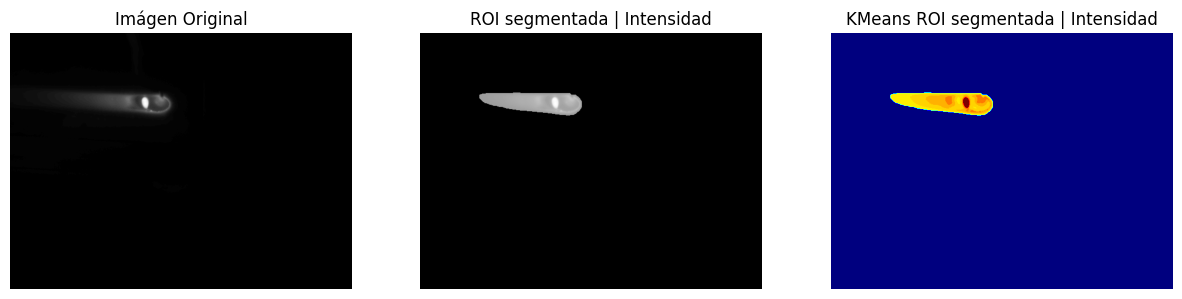

In [7]:
plot_roi_result(target_image, mask_method_with_threshold, "Intensidad")

- #### *Máscara segmentada por forma (M2)*

Centroides: [102.246216  94.862465 112.417175  86.979744 138.31285 ]


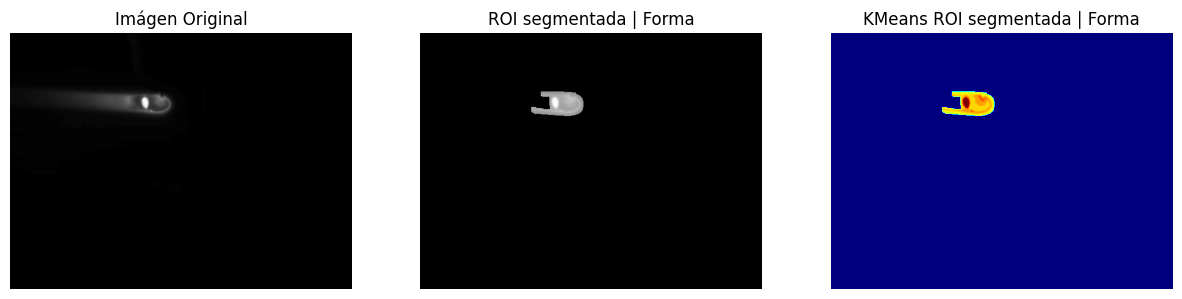

In [8]:
plot_roi_result(target_image, mask_method_with_gradient, "Forma")

- #### *Máscara segmentada por región (M3)*

Centroides: [ 92.82655  137.71658  109.184044 102.675896  97.78077 ]


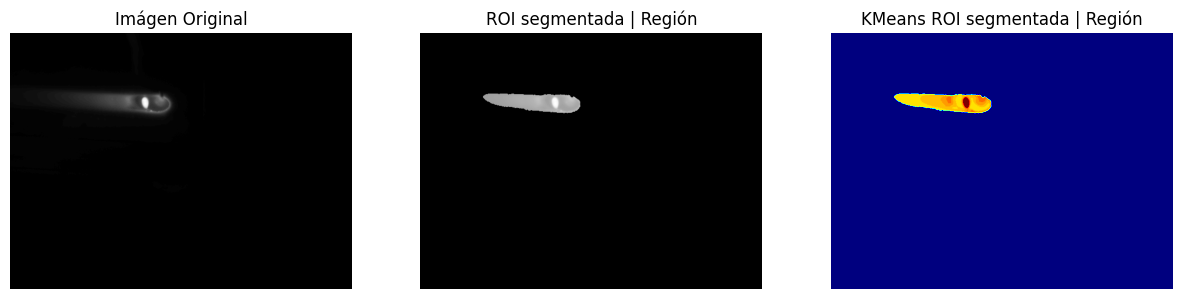

In [9]:
plot_roi_result(target_image, mask_method_with_markers, "Región")

### K-Means sin aplicación de ROI

In [10]:
def kmeans_without_roi(train_img_path, n_clusters = 5):
    start_total_time = time.time()

    images = os.listdir(train_img_path)

    all_pixels = []
    total_images = 0
    valid_images = 0

    for file_name in images:

        total_images += 1

        img_path = os.path.join(train_img_path, file_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        if img is None:
            continue

        all_pixels.append(img.flatten())
        valid_images += 1

    if len(all_pixels) == 0:
        raise ValueError("No valid images found in dataset.")

    # Unimos todos los píxeles del dataset
    pixel_values = np.concatenate(all_pixels)
    total_pixels = len(pixel_values)

    pixel_values = np.float32(pixel_values.reshape(-1, 1))

    criteria = (
        cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER,
        100,
        0.2
    )

    start_kmeans_time = time.time()

    _, labels, centers = cv2.kmeans(
        pixel_values,
        n_clusters,
        None,
        criteria,
        10,
        cv2.KMEANS_RANDOM_CENTERS
    )

    end_kmeans_time = time.time()
    end_total_time = time.time()

    centers = centers.flatten()
    labels = labels.flatten()

    print("=========== K-MEANS REPORT WITHOUT ROI ===========")
    print(f"Total images found:        {total_images}")
    print(f"Images used:               {valid_images}")
    print(f"Total pixels used:         {total_pixels}")
    print(f"K-means time:              {end_kmeans_time - start_kmeans_time:.4f} sec")
    print(f"Total pipeline time:       {end_total_time - start_total_time:.4f} sec")
    print("============================ CLUSTER SUMMARY ============================")
    for i in range(n_clusters):
        cluster_pixels = pixel_values[labels == i]

        if cluster_pixels.size > 0:
            c_min = np.min(cluster_pixels)
            c_max = np.max(cluster_pixels)
            c_center = centers[i]

            print(
                f"Cluster: {i:<3} | "
                f"Center: {c_center:<8.2f} | "
                f"Min: {c_min:<6.0f} | "
                f"Max: {c_max:<6.0f} | "
                f"Pixels: {len(cluster_pixels)}"
            )
    print("=========================================================================")

    return centers

In [12]:
centers = kmeans_without_roi(train_images_path, 7)

centers_sorted = np.round(np.sort(centers), 2)

centers_str = ", ".join(f"{c:.2f}" for c in centers_sorted)

print("Centers", centers_str)

=========== K-MEANS REPORT WITHOUT ROI ===========
Total images found:        278
Images used:               278
Total pixels used:         85184400
K-means time:              139.9846 sec
Total pipeline time:       140.5693 sec
============== CLUSTER SUMMARY ===================
Cluster: 0   | Center: 3.95     | Min: 3      | Max: 6      | Pixels: 9704
Cluster: 1   | Center: 21.99    | Min: 21     | Max: 23     | Pixels: 489
Cluster: 2   | Center: 0.87     | Min: 0      | Max: 2      | Pixels: 70933
Cluster: 3   | Center: 25.29    | Min: 24     | Max: 254    | Pixels: 85098876
Cluster: 4   | Center: 8.55     | Min: 7      | Max: 11     | Pixels: 2433
Cluster: 5   | Center: 14.02    | Min: 12     | Max: 16     | Pixels: 1185
Cluster: 6   | Center: 18.43    | Min: 17     | Max: 20     | Pixels: 780
Centers 0.87, 3.95, 8.55, 14.02, 18.43, 21.99, 25.29


### K-Means con aplicación de ROI

In [15]:
def kmeans_with_roi(dataset_path, n_clusters=5, custom_roi_mask=None):
    start_total_time = time.time()

    all_roi_pixels = []
    total_images = 0
    valid_images = 0

    for file_name in os.listdir(dataset_path):

        total_images += 1

        img_path = os.path.join(dataset_path, file_name)
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        if image is None:
            continue

        mask = custom_roi_mask(image)

        roi_pixels = image[mask == 255]

        if len(roi_pixels) > 0:
            all_roi_pixels.append(roi_pixels)
            valid_images += 1

    if len(all_roi_pixels) == 0:
        raise ValueError("No ROI pixels found in dataset.")

    all_roi_pixels = np.concatenate(all_roi_pixels)
    total_pixels = len(all_roi_pixels)

    all_roi_pixels = np.float32(all_roi_pixels.reshape(-1, 1))

    criteria = (
        cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER,
        100,
        0.2
    )

    start_kmeans_time = time.time()

    _, labels, centers = cv2.kmeans(
        all_roi_pixels,
        n_clusters,
        None,
        criteria,
        10,
        cv2.KMEANS_RANDOM_CENTERS
    )

    end_kmeans_time = time.time()
    end_total_time = time.time()

    centers = centers.flatten()
    labels = labels.flatten()

    print("=========== K-MEANS REPORT WITH ROI ===========")
    print(f"Total images found:        {total_images}")
    print(f"Images used:               {valid_images}")
    print(f"Total pixels used:         {total_pixels}")
    print(f"K-means time:              {end_kmeans_time - start_kmeans_time:.4f} sec")
    print(f"Total pipeline time:       {end_total_time - start_total_time:.4f} sec")
    print("============================ CLUSTER SUMMARY ============================")
    for i in range(n_clusters):
        cluster_pixels = all_roi_pixels[labels == i]

        if cluster_pixels.size > 0:
            c_min = np.min(cluster_pixels)
            c_max = np.max(cluster_pixels)
            c_center = centers[i]
            count = len(cluster_pixels)

            print(
                f"Cluster: {i:<3} | "
                f"Center: {c_center:<8.2f} | "
                f"Min: {c_min:<6.0f} | "
                f"Max: {c_max:<6.0f} | "
                f"Pixels: {count:<8}"
            )
    print("=========================================================================")

    return centers

In [16]:
centers = kmeans_with_roi(train_images_path, 7, prepare_and_get_roi_on_image)

centers_sorted = np.round(np.sort(centers), 2)

centers_str = ", ".join(f"{c:.2f}" for c in centers_sorted)

print("Centers", centers_str)

=========== K-MEANS REPORT WITH ROI ===========
Total images found:        278
Images used:               271
Total pixels used:         2582952
K-means time:              3.2719 sec
Total pipeline time:       4.0074 sec
============================ CLUSTER SUMMARY ============================
Cluster: 0   | Center: 115.52   | Min: 111    | Max: 123    | Pixels: 212792  
Cluster: 1   | Center: 49.74    | Min: 20     | Max: 66     | Pixels: 1836    
Cluster: 2   | Center: 104.51   | Min: 100    | Max: 110    | Pixels: 516185  
Cluster: 3   | Center: 207.36   | Min: 170    | Max: 254    | Pixels: 186     
Cluster: 4   | Center: 93.54    | Min: 89     | Max: 99     | Pixels: 1159842 
Cluster: 5   | Center: 130.84   | Min: 124    | Max: 169    | Pixels: 40675   
Cluster: 6   | Center: 82.95    | Min: 67     | Max: 88     | Pixels: 651436  
Centers 49.74, 82.95, 93.54, 104.51, 115.52, 130.84, 207.36


Llamando al centro mas cercano

In [17]:
def segment_with_trained_centers(image, centers):
    mask = prepare_and_get_roi_on_image(image)

    segmented = np.zeros_like(image)

    roi_pixels = image[mask == 255]

    if len(roi_pixels) == 0:
        return segmented

    roi_pixels = roi_pixels.reshape(-1, 1)

    # Distancia absoluta porque es escala de grises
    distances = np.abs(roi_pixels - centers.reshape(1, -1))

    closest_center = np.argmin(distances, axis=1)

    segmented_values = centers[closest_center]

    segmented[mask == 255] = segmented_values

    return segmented

Obtener una imagen random del grupo de test

In [18]:
def get_random_image_from_test_dataset(path):
    image_files = [
        f for f in os.listdir(path)
        if f.lower().endswith((".tif", ".tiff"))
    ]

    random_file = random.choice(image_files)

    random_image_path = os.path.join(path, random_file)

    print(f"Image selected: {random_file}")

    return random_image_path

get_random_image_from_test_dataset("resources/dataset/soldadura/test/")

Image selected: 1734589595120.tif


'resources/dataset/soldadura/test/1734589595120.tif'

Prueba con un solo elemento del dataset | PINTA TODA EL AREA DE INTERES

Image selected: 1734589595323.tif


(np.float64(-0.5), np.float64(639.5), np.float64(479.5), np.float64(-0.5))

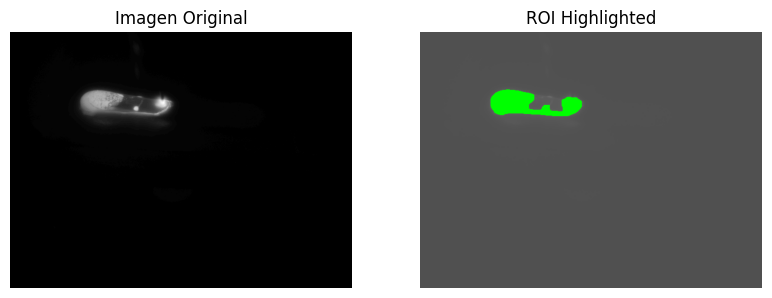

In [19]:
random_image = get_random_image_from_test_dataset("resources/dataset/soldadura/test/")

image = cv2.imread(random_image, cv2.IMREAD_GRAYSCALE)

# Segmentación
sg = segment_with_trained_centers(image, centers)

# Obtener máscara ROI
mask = prepare_and_get_roi_on_image(image)

# Convertir a color
color_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

# Pintar ROI en verde fosforescente
color_image[mask == 255] = [0, 255, 0]

# Mostrar
plt.figure(figsize=(15,5))

plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title("Imagen Original")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB))
plt.title("ROI Highlighted")
plt.axis("off")

Prueba con un solo elemento del dataset | PINTA LOS BORDES DE INTERES

Image selected: 1734589458844.tif


(np.float64(-0.5), np.float64(639.5), np.float64(479.5), np.float64(-0.5))

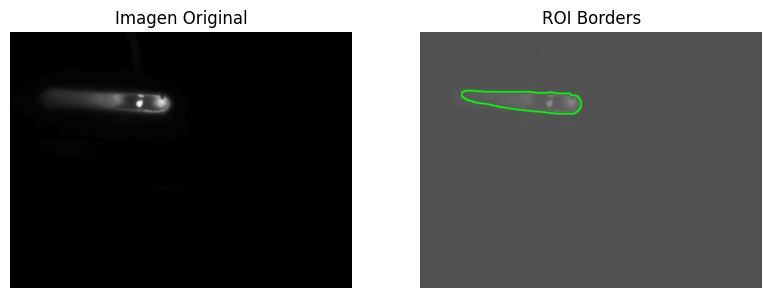

In [20]:
random_image = get_random_image_from_test_dataset("resources/dataset/soldadura/test/")

image = cv2.imread(random_image, cv2.IMREAD_GRAYSCALE)

# Obtener máscara ROI
mask = prepare_and_get_roi_on_image(image)

# Convertir imagen a color
color_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

# Encontrar contornos
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Dibujar contornos en verde fosforescente
cv2.drawContours(color_image, contours, -1, (0,255,0), 2)  # 2 = grosor

# Mostrar

plt.figure(figsize=(15,5))

plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title("Imagen Original")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB))
plt.title("ROI Borders")
plt.axis("off")

PINTANDO POR COLORES

In [21]:
def apply_fixed_clusters(image):
    if image is None: return print("No se pudo cargar la imagen")

    centers = np.array([82.23, 91.95, 98.95, 107.38, 116.90, 131.81, 207.36], dtype=np.float32)

    pixel_values = image.astype(np.float32)
    distances = np.abs(pixel_values[:, :, np.newaxis] - centers)
    labels = np.argmin(distances, axis=2)

    colors = [
        [255, 0, 0],    # Cluster 0: Azul
        [0, 255, 0],    # Cluster 1: Verde
        [0, 0, 255],    # Cluster 2: Negro
        [255, 255, 0],  # Cluster 3: Cyan
        [255, 0, 255],  # Cluster 4: Magenta
        [0, 255, 255],  # Cluster 5: Amarillo
        [255, 255, 255] # Cluster 6: Blanco
    ]

    h, w = image.shape
    colored_img = np.zeros((h, w, 3), dtype=np.uint8)

    for i in range(len(centers)):
        colored_img[labels == i] = colors[i]

    plt.style.use('dark_background')
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image, cmap='gray')
    plt.title("Imagen Original")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(cv2.cvtColor(colored_img, cv2.COLOR_BGR2RGB))
    plt.title("Segmentación por Colores")
    plt.axis('off')

    return None

Image selected: 1734589666775.tif


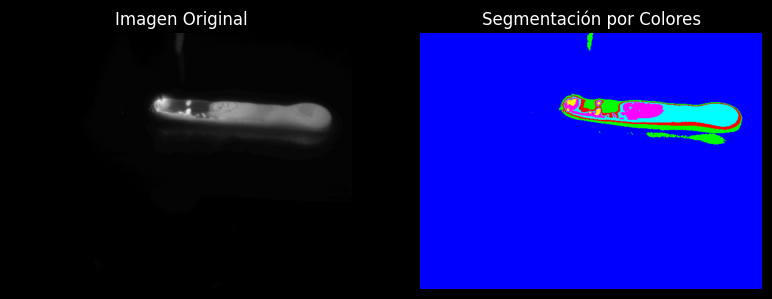

In [25]:
random_image = get_random_image_from_test_dataset("resources/dataset/soldadura/test/")

image = cv2.imread(random_image, cv2.IMREAD_GRAYSCALE)

apply_fixed_clusters(image)

Rocorrer todo el dataset de pruebas

In [ ]:
test_path = "resources/dataset_test"

for file_name in os.listdir(test_path):

    img_path = os.path.join(test_path, file_name)
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    if image is None:
        continue

    segmented = segment_with_trained_centers(image, centers)

    cv2.imshow("Segmented", segmented)
    cv2.waitKey(0)

cv2.destroyAllWindows()